# Word Embedding
Study the best word embedding method for this problem.

**WARNING : this is a proof-of-concept demo. Be aware that the dictionary it outputs directly depends on the given `word_counts.json` file.**

In [1]:
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Update path in order to correctly resolve python modules and files
os.chdir("..")
sys.path.append("src")

First, we can generate a word count from the training dataset. Note that when testing the efficiency of a model, the dictionary will have to be generated from the x% data taken from the training dataset for training, and not the part of the training dataset used for testing.

In [3]:
from src.word_embedding import words_label_count  # noqa: E402

word_counts = words_label_count()

# Write the output to a file
with open("word_counts.json", "w") as outfile:
    json.dump(word_counts, outfile)

Utterance 72623 of - 72623
Done
Positive utterances : 13292 / 72623 (18.30274%)


Load the word count data

In [4]:
# Open the word count file
with open("word_counts.json", "r") as file:
    word_counts: dict[str, tuple[int, int]] = json.load(file)

# Prepare the data as numpy arrays
POSITIVE_RATIO = 0.1830274  # Computed from the whole training dataset
counts = np.array(list(word_counts.values()), dtype=np.float32)
occurrences = np.sum(counts, axis=1)
# Normalize the irrelevant counts with the ratio
counts[:, 0] *= POSITIVE_RATIO
labels = np.array(list(word_counts.keys()))

Relevant to irrelevant utterances ratio : 0.1830274
Total number of unique words : 9030


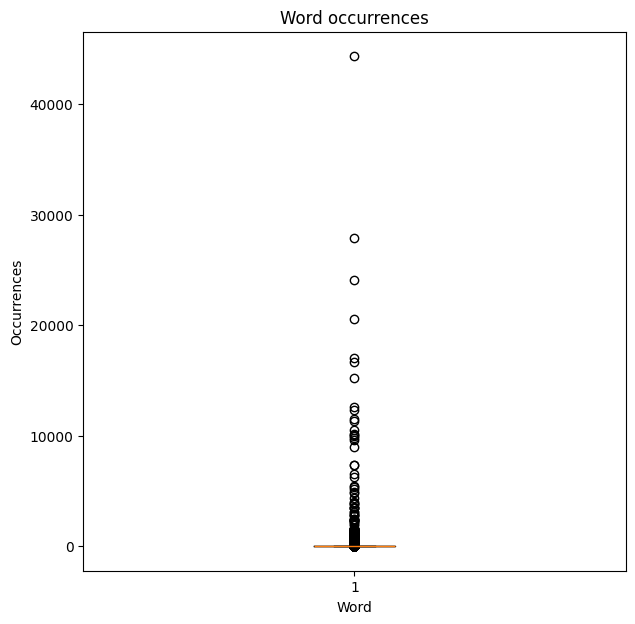

In [5]:
# Some base analytics
print("Relevant to irrelevant utterances ratio :", POSITIVE_RATIO)
print("Total number of unique words :", len(labels))

plt.figure(figsize=(7, 7))
plt.title("Word occurrences")
plt.xlabel("Word")
plt.ylabel("Occurrences")
plt.boxplot(occurrences)
plt.show()

We can see that A LOT of words occur very rarely, too rarely to be useful in a custom embedding... We need to filter them.

We can keep only the upper 5% percentile of the words in order to work with words that happen often.

The threshold value for the 95 th percentile is 109.0
Left words after filtering : 451


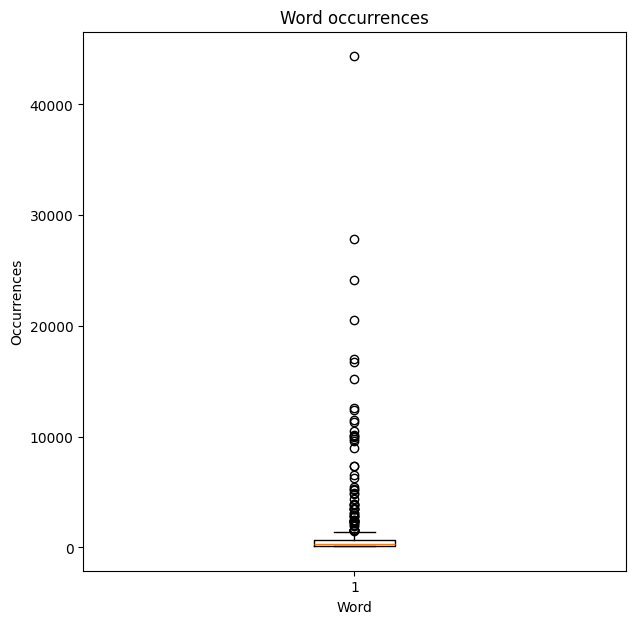

In [6]:
percentile_threshold = 95
occurence_threshold = np.percentile(occurrences, percentile_threshold)

print(
    "The threshold value for the",
    percentile_threshold,
    "th percentile is",
    occurence_threshold,
)

# Build a mask and filter the data
mask = occurrences > occurence_threshold
filtered_counts = counts[mask]
filtered_labels = labels[mask]
filtered_occurrences = occurrences[mask]

print("Left words after filtering :", len(filtered_labels))


plt.figure(figsize=(7, 7))
plt.title("Word occurrences")
plt.xlabel("Word")
plt.ylabel("Occurrences")
plt.boxplot(filtered_occurrences)
plt.show()

We should then use a score function to evaluate which words are most likely to be associated with a relevant utterance.

We can use the following score function :
$$
score = \frac{relevant\_count - irrelevant\_count}{relevant\_count + irrelevant\_count}
$$

In [7]:
score = (filtered_counts[:, 1] - filtered_counts[:, 0]) / (
    filtered_counts[:, 1] + filtered_counts[:, 0]
)

We can then show a histogram of the obtained scores. 1 means a perfect relevance association, 0 means that the word is useless, and -1 means a perfect association to irrelevance. We will only keep words with a score high enough.

A score of more than 0.5 guarantees that the word has been associated to relevant utterances 3 times more than to irrelevant utterances.

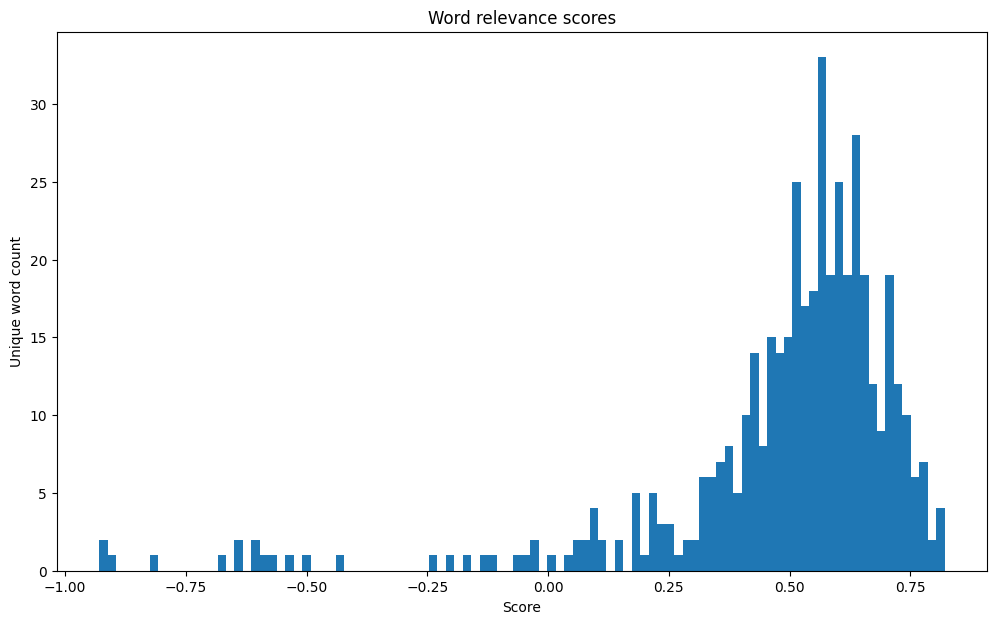

In [8]:
plt.figure(figsize=(12, 7))
plt.title("Word relevance scores")
plt.xlabel("Score")
plt.ylabel("Unique word count")
plt.hist(score, bins=100)
plt.show()

We can print (out of curiosity) the n best and worst words according to this score.

In [9]:
sorted_indices = np.argsort(score)

n = 20
n_most_relevant = filtered_labels[sorted_indices[-n:]]
n_least_relevant = filtered_labels[sorted_indices[:n]]

print("Most relevant words :", n_most_relevant)
print("Least relevant words :", n_least_relevant)

Most relevant words : ['euros' 'having' 'plastic' 'interface' 'user' 'budget' 'power' 'design'
 'percent' 'solar' 'users' 'evaluation' 'speech' 'younger' 'energy'
 'display' 'voice' 'kinetic' 'recognition' 'functional']
Least relevant words : ['mm-hmm' 'hmm' 'yep' 'uh-huh' 'alright' "'kay" 'sorry' 'oh' 'thank'
 'yeah' 'okay' 'huh' 'ah' 'yes' 'no' 'mm' 'right' 'great' 'true' 'fine']


Finally, we can save the words with a score above 0.5 to a dictionary file, for use in our custom text embedder.

The words can be loaded using `np.genfromtxt` with `dtype=str` directly into a numpy array.

In [10]:
chosen_words = filtered_labels[score > 0.5]

print("Chosen words :", len(chosen_words))
print(chosen_words)

with open("dictionary.txt", "w") as file:
    np.savetxt(file, chosen_words, fmt="%s")

Chosen words : 290
['um' 'is' 'the' 'meeting' 'for' 'our' 'project' 'and' "we're" 'gonna'
 'be' 'over' 'twenty' 'five' 'minutes' 'first' 'of' 'to' 'kind' 'make'
 'that' 'we' 'each' 'other' 'want' 'an' 'designer' 'uh' 'marketing' 'user'
 'interface' 'a' 'new' 'remote' 'control' 'have' 'actually' 'on' 'design'
 'as' 'trendy' 'were' 'are' 'different' 'in' 'about' 'same' 'thing' 'work'
 'then' 'at' 'point' 'try' 'out' 'up' 'who' 'would' 'will' 'basically'
 'they' 'take' 'lot' 'from' 'their' 'small' 'when' 'with' 'them' "there's"
 'much' 'discuss' 'feel' 'whole' 'more' 'might' 'think' 'off' 'top' 'big'
 'most' 'come' 'everything' 'quite' 'by' 'way' 'choose' 'own' 'look'
 'things' 'where' 'which' 'only' 'after' 'had' 'room' 'probably' 'little'
 'has' 'been' 'maybe' 'find' 'down' 'need' 'fifty' 'cost' 'than' 'twelve'
 'euros' 'percent' 'price' 'together' 'or' 'sell' 'going' 'how' 'if'
 'something' 'stuff' 'buttons' 'thinking' 'market' 'another' "it'll"
 'money' 'people' 'basic' 'product' 'suc